# Hlasová analýza pro detekci patologických změn

**Autor**: Martin Žoha

**Datum**: 29. 6. 2025

## Úvod

Seminární práce se zabývá analýzou hlasových záznamů z [PhysioNet VOICED Database](https://physionet.org/content/voiced/1.0.0/). Hlasové záznamy jsou načteny do prostředí Python. Následně jsou signály dle jejich vlastností binárně klasifikovány jako zdravé a patologické. K řazení jsou využita předem stanovená pravidla. Ke klasifikaci není využita žádná metoda strojového učení. Přesnost rozdělení je ověřena na experty anotovaných datech.

## Zadání

Zdrojem dat pro seminární práci je databáze PhysioNet. Konkrétně jde o databázi VOICED Database,
které jsou pořízeny záznamy hlasu od 208 subjektů nichž 150 má patologickou změnu a 58 subjektů
má normální hlas. Více o databázi lze nalézt zde: [https://physionet.org/content/voiced/1.0.0/](https://physionet.org/content/voiced/1.0.0/). Každý
subjekt má tři základní soubory typické pro databázi PhysioNet. Je jím hlavičkový soubor, kde lze nalézt
mimo jiné také diagnózu, textový a datový sobor, kde je samotný záznam hlasu. Základním úkolem je
zorientovat se ve formátu, ve kterém jsou data uložena a načíst tato data do prostředí Pythonu. Pro
manipulace s daty lze využít předpřipravené nástroje WFDB ze stránek Physionet.org.

Ve zdrojové databázi najdete celkem 208 hlasových záznamů písmene a. Pomocí Vámi vybrané
techniky v časové nebo frekvenční oblasti klasifikujte zvukové záznamy na dobré a patologické.
V případě patologických poté klasifikujte jednotlivé poruchy. Jejich výčet najdete buď
v hlavičkových souborech nebo v propisu databáze. Pro klasifikaci do jednotlivých skupin
použijte veškeré techniky, které jste si v rámci kurzu osvojili včetně Fourierovy a kepstrální
analýzy. Úspěšnost Vašeho postupu porovnejte s anotacemi, resp. rozřazením do skupin, které
provedli experti, kteří data pořizovali.

## Zpracování

Ke zpracování je využito prostředí Jupyter Notebook. Kód je rozdělen do logických celků. Doporučený postup je spuštění buněk 1-11 pro definici všech potřebných funkcí a následně postupovat sekvenčně. Hlavní analýza je zpracována v buňkách 12-18. Buňky 19-20 jsou doplňující prouzkoumání dat pro případnou optimalizaci klasifikačních pravidel. Veškerý kód je doplněn komentářem autora.

### 1.-2. Importy a počáteční nastavení

Tento kód slouží jako úvodní část projektu. Nejprve importuje nezbytné knihovny pro zpracování signálů, vizualizaci, numerické výpočty a strojové učení. Potlačuje varování, aby výsledky nebyly zahlceny zbytečnými výstupy. Poté definuje čtyři datové třídy (`Config`, `AudioFeatures`, `LoadResult`, `ClassificationResult`, `EvaluationMetrics`), které slouží ke strukturovanému uchovávání konfiguračních parametrů, extrahovaných akustických příznaků, načtených zvukových dat a výsledků klasifikace i hodnocení.

Konkrétně třída `Config` uchovává základní nastavení analýzy včetně cesty ke zvukovým datům, vzorkovací frekvence a prahových hodnot pro vybrané příznaky. Třída `AudioFeatures` obsahuje extrahované vlastnosti signálů jako je variabilita výšky tónu, harmonicko-šumový poměr (HNR), MFCC koeficienty, nulové přechody (ZCR) a spektrální centroid. `LoadResult` ukládá načtené signály, jejich popisky a případné chyby. `ClassificationResult` uchovává výsledky klasifikace a `EvaluationMetrics` poskytuje metriky přesnosti modelu pro zdravé i patologické případy. Tento návrh podporuje přehlednou a škálovatelnou implementaci následného zpracování a hodnocení.


In [37]:
# 1 Imports and Setup

"""
Voice Analysis for Pathological Speech Detection
"""
import concurrent.futures
import warnings
from dataclasses import dataclass, field
from pathlib import Path
from typing import Any

import librosa
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import wfdb
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")


In [ ]:
# 2 Configuration and Data Classes


@dataclass
class Config:
    """Configuration parameters for voice analysis."""

    audio_directory: str = "voiced/"
    sampling_rate: int = 8000
    n_mfcc: int = 13
    n_workers: int = 4
    thresholds: dict[str, float] = field(
        default_factory=lambda: {
            "pitch_variability": 196.380,
            "hnr": 39.998,
            "mfcc": -26.482,
            "zcr": 0.235,
            "spectral_centroid": 1027.502,
        }
    )


@dataclass
class AudioFeatures:
    """Container for extracted audio features."""

    pitch_variabilities: list[float]
    hnr_scores: list[float]
    mfcc_features: list[np.ndarray]
    zcr_values: list[float]
    spectral_centroid_values: list[float]

    @property
    def n_samples(self) -> int:
        return len(self.pitch_variabilities)


@dataclass
class LoadResult:
    """Result of loading audio data."""

    audio_signals: list[np.ndarray]
    labels: list[str]
    annotations: list[str]
    errors: list[str]


@dataclass
class ClassificationResult:
    """Result of classification."""

    classifications: list[str]
    threshold: float | None = None
    feature_scores: list[float] | None = None


@dataclass
class EvaluationMetrics:
    """Evaluation metrics."""

    overall_accuracy: float
    healthy_accuracy: float
    pathological_accuracy: float
    total_samples: int
    correct_predictions: int
    healthy_correct: int
    pathological_correct: int
    healthy_total: int
    pathological_total: int

### 3. Načítání souborů

Tato část kódu implementuje sadu funkcí pro načítání a kategorizaci zvukových dat uložených ve formátu PhysioNet (formáty .dat a .hea), přičemž využívá paralelní zpracování pro zvýšení rychlosti. Funkce `load_label_from_file` extrahuje diagnózu ze souboru s příponou `.hea`. V případě chyby nebo neexistence diagnózy vrací implicitně kategorii „Healthy“. Funkce `load_single_audio_file` načítá konkrétní zvukový soubor a jeho odpovídající popisek, přičemž v případě chyby vrací informaci o chybě a neutrální hodnoty.

Funkce `create_label_cache` sestavuje slovník popisků pro všechny záznamy v daném adresáři, což usnadňuje pozdější vyhodnocení přesnosti. Klíčovou funkcí je `load_all_audio_data`, která využívá vlákna (`ThreadPoolExecutor`) k paralelnímu načítání všech `.dat` souborů. Načtené výsledky jsou rozděleny na úspěšně načtené signály a chyby. Výsledkem je instance třídy `LoadResult`, která obsahuje nahrané signály, jejich kategorie, anotace získané z cache a případné chyby. Tento přístup zajišťuje robustní a efektivní načítání většího objemu dat pro další akustickou analýzu.


In [ ]:
# 3 File Loading Functions


def load_label_from_file(label_path: Path) -> str:
    """Load label from file."""
    try:
        with open(label_path) as f:
            content = f.read().strip()
            if "<diagnoses>" in content:
                diagnosis = content.split("<diagnoses>: ")[1].strip()
                if " <" in diagnosis:
                    diagnosis = diagnosis.split(" <")[0]
                return "Healthy" if diagnosis.lower() == "healthy" else "Pathological"
            else:
                return "Healthy"
    except FileNotFoundError:
        return "Healthy"


def load_single_audio_file(
    file_path: Path,
) -> tuple[np.ndarray | None, str, str | None]:
    """Load a single audio file."""
    base_name = file_path.stem
    record_path = str(file_path.parent / base_name)

    try:
        record = wfdb.rdrecord(record_path)
        signal = record.p_signal.flatten()
        label_path = file_path.parent / f"{base_name}.hea"
        label = load_label_from_file(label_path)
        return signal, label, None
    except Exception as e:
        return None, "Unknown", str(e)


def create_label_cache(audio_dir: Path) -> dict[str, str]:
    """Create label cache for all files."""
    cache = {}
    for hea_file in audio_dir.glob("*.hea"):
        base_name = hea_file.stem
        cache[base_name] = load_label_from_file(hea_file)
    return cache


def load_all_audio_data(audio_dir: Path, n_workers: int = 4) -> LoadResult:
    """Load all audio data with parallel processing."""
    dat_files = list(audio_dir.glob("*.dat"))

    with concurrent.futures.ThreadPoolExecutor(max_workers=n_workers) as executor:
        futures = [executor.submit(load_single_audio_file, file) for file in dat_files]
        results = [
            future.result() for future in concurrent.futures.as_completed(futures)
        ]

    # Separate successful loads from errors
    audio_signals = []
    labels = []
    errors = []

    for signal, label, error in results:
        if signal is not None:
            audio_signals.append(signal)
            labels.append(label)
        else:
            errors.append(error or "Unknown error")

    # Create annotations from label cache
    label_cache = create_label_cache(audio_dir)
    annotations = list(label_cache.values())

    return LoadResult(
        audio_signals=audio_signals,
        labels=labels,
        annotations=annotations,
        errors=errors,
    )


### 4 Extrakce akustických příznaků - základní příznaky

Tato část kódu se zaměřuje na výpočet základních akustických příznaků ze zvukových signálů pomocí frekvenční analýzy. Funkce `calculate_fft_features` provádí rychlou Fourierovu transformaci (FFT) a vrací spektrum frekvencí, hustotu výkonového spektra (PSD) a základní frekvenci (fundamentální tón). Hustota výkonu je zde určena jako čtverec amplitudy spektra, normalizovaný délkou signálu, což je běžný přístup při analýze spektrální energie. Základní frekvence je identifikována jako frekvence s nejvyšší energetickou složkou v PSD.

Funkce `calculate_hnr` následně využívá výstupy FFT k výpočtu harmonicko-šumového poměru (HNR). Tento poměr se určuje jako podíl energie ve frekvencích blízkých harmonickým násobkům základní frekvence vůči energii v ostatních frekvencích, které jsou považovány za šum. Dále funkce `extract_pitch_variability` odhaduje změny výšky tónu pomocí metody `piptrack` z knihovny Librosa, která sleduje harmonické komponenty v čase. Směrodatná odchylka platných výšek tónu (ignorující nulové hodnoty) slouží jako míra kolísání výšky řeči, což je významný parametr při hodnocení patologických hlasových projevů.


In [ ]:
# 4 Feature Extraction Functions - Basic Features


def calculate_fft_features(
    signal: np.ndarray, sampling_rate: int
) -> tuple[np.ndarray, np.ndarray, float]:
    """Calculate FFT features."""
    fft_result = np.fft.rfft(signal)
    freq = np.fft.rfftfreq(len(signal), d=1 / sampling_rate)
    psd = np.abs(fft_result) ** 2 / len(signal)
    fundamental = freq[np.argmax(psd)]
    return freq, psd, fundamental


def calculate_hnr(freq: np.ndarray, psd: np.ndarray, fundamental: float) -> float:
    """Calculate HNR."""
    if fundamental == 0:
        return 0

    harmonic_freqs = fundamental * np.arange(1, 10)
    harmonic_power = sum(
        np.sum(psd[(freq >= f - 50) & (freq <= f + 50)]) for f in harmonic_freqs
    )
    noise_mask = (freq < harmonic_freqs[0] - 50) | (freq > harmonic_freqs[-1] + 50)
    noise_power = np.sum(psd[noise_mask])

    return harmonic_power / noise_power if noise_power > 0 else 0


def extract_pitch_variability(signal: np.ndarray, sampling_rate: int) -> float:
    """Extract pitch variability."""
    pitch_track, _ = librosa.piptrack(y=signal, sr=sampling_rate)
    valid_pitches = np.max(pitch_track, axis=0)
    valid_pitches = valid_pitches[valid_pitches > 0]
    return np.std(valid_pitches) if len(valid_pitches) > 0 else 0


### 5 Extrakce komplexních akustických příznaků

Tato část kódu implementuje extrakci komplexních zvukových příznaků, které se používají pro analýzu a klasifikaci řečových signálů. Funkce `extract_mfcc_features` počítá Mel-frekvenční kepstrální koeficienty (MFCC), které slouží k modelování spektrálních charakteristik lidské řeči. Funkce `extract_zcr` vypočítává průměrnou míru nulových přechodů (Zero Crossing Rate), zatímco `extract_spectral_centroid` určuje spektrální centroid, který udává těžiště frekvenčního spektra a koreluje s vnímanou ostrostí zvuku. Tyto funkce používají knihovnu Librosa.

Funkce `extract_single_signal_features` slučuje výše zmíněné výpočty spolu s výpočtem kolísání výšky tónu a HNR do jednoho slovníku příznaků pro jednotlivý signál. Funkce `extract_all_features` pak zajišťuje paralelní zpracování všech signálů pomocí více vláken, čímž se výrazně zkracuje výpočetní čas při analýze většího množství dat. Výsledné příznaky jsou seskupeny do instance třídy `AudioFeatures`, zatímco `progress_updates` poskytuje jednoduché sledování postupu výpočtu.


In [ ]:
# 5 Feature Extraction Functions - Audio Features


def extract_mfcc_features(
    signal: np.ndarray, sampling_rate: int, n_mfcc: int
) -> np.ndarray:
    """Extract MFCC features."""
    return librosa.feature.mfcc(y=signal, sr=sampling_rate, n_mfcc=n_mfcc)


def extract_zcr(signal: np.ndarray) -> float:
    """Extract zero crossing rate."""
    return np.mean(librosa.feature.zero_crossing_rate(signal))


def extract_spectral_centroid(signal: np.ndarray, sampling_rate: int) -> float:
    """Extract spectral centroid."""
    return np.mean(librosa.feature.spectral_centroid(y=signal, sr=sampling_rate))


def extract_single_signal_features(
    signal: np.ndarray, config: Config
) -> dict[str, Any]:
    """Extract all features for a single signal."""
    # Pitch variability
    pitch_variability = extract_pitch_variability(signal, config.sampling_rate)

    # FFT-based features
    freq, psd, fundamental = calculate_fft_features(signal, config.sampling_rate)
    hnr = calculate_hnr(freq, psd, fundamental)

    # MFCC
    mfcc = extract_mfcc_features(signal, config.sampling_rate, config.n_mfcc)

    # ZCR and Spectral Centroid
    zcr = extract_zcr(signal)
    spectral_centroid = extract_spectral_centroid(signal, config.sampling_rate)

    return {
        "pitch_variability": pitch_variability,
        "hnr": hnr,
        "mfcc": mfcc,
        "zcr": zcr,
        "spectral_centroid": spectral_centroid,
    }


def extract_all_features(
    audio_signals: list[np.ndarray], config: Config
) -> tuple[AudioFeatures, list[int]]:
    """Extract features from all signals with parallel processing."""
    n_signals = len(audio_signals)

    with concurrent.futures.ThreadPoolExecutor(
        max_workers=config.n_workers
    ) as executor:
        futures = [
            executor.submit(extract_single_signal_features, signal, config)
            for signal in audio_signals
        ]
        results = [
            future.result() for future in concurrent.futures.as_completed(futures)
        ]

    # Collect progress information
    progress_updates = list(range(50, n_signals + 1, 50))

    # Organize results
    pitch_variabilities = [r["pitch_variability"] for r in results]
    hnr_scores = [r["hnr"] for r in results]
    mfcc_features = [r["mfcc"] for r in results]
    zcr_values = [r["zcr"] for r in results]
    spectral_centroid_values = [r["spectral_centroid"] for r in results]

    features = AudioFeatures(
        pitch_variabilities=pitch_variabilities,
        hnr_scores=hnr_scores,
        mfcc_features=mfcc_features,
        zcr_values=zcr_values,
        spectral_centroid_values=spectral_centroid_values,
    )

    return features, progress_updates


### 6 Klasifikační funkce

V této části kódu jsou implementovány klasifikační funkce, které rozhodují, zda daný hlasový záznam vykazuje známky patologie. Funkce `classify_by_pitch_variability` využívá jednoduchý přístup založený na kolísání výšky tónu – vypočítá 19. percentil hodnot jako prahovou mez a určí, zda daná hodnota přesahuje tuto hranici. Takto nízký percentil byl zvolen na základě několika pokusů. Kvůli převaze patologických signálů v databázi nemůže být práh příliš benevolentní. Výsledkem je seznam klasifikací spolu s použitým prahem, přičemž vyšší kolísání tónu naznačuje patologický stav.

Funkce `classify_combined_features` představuje sofistikovanější přístup kombinující více příznaků – HNR, MFCC, ZCR a spektrální centroid – pomocí váženého skórování. Každý příznak je posuzován vzhledem k prahové hodnotě definované v konfiguraci a je mu přidělena váha podle jeho významu. Po normalizaci dat je každému záznamu přiděleno souhrnné skóre a klasifikace „Healthy“ je udělena pouze tehdy, pokud skóre překročí hranici 0.5. Tento přístup umožňuje robustnější klasifikaci založenou na vícero akustických charakteristikách současně. Zároveň se ovšem tento přístup ukázal velmi problematický pro přesné určování kategorie. Bez užití metod strojového učení není téměř možné optimalizovat jednotlivé váhy a potřebné skóre pro zařazení do kategorií, přestože toto společně s nastavením prahových hodnot má nejvyšší dopad na výslednou kategorizaci.


In [ ]:
# 6 Classification Functions


def classify_by_pitch_variability(
    pitch_variabilities: list[float],
) -> ClassificationResult:
    """Classify based on pitch variability."""
    pitch_array = np.array(pitch_variabilities)
    threshold = np.percentile(pitch_array, 19)
    classifications = np.where(
        pitch_array > threshold, "Pathological", "Healthy"
    ).tolist()

    return ClassificationResult(classifications=classifications, threshold=threshold)


def classify_combined_features(
    features: AudioFeatures, config: Config
) -> ClassificationResult:
    """Enhanced combined classification with weighted scoring."""
    feature_weights = {
        "hnr": 0.3,
        "mfcc": 0.25,
        "zcr": 0.2,
        "spectral_centroid": 0.25,
    }
    thresholds = config.thresholds

    mfcc_means = [np.mean(mfcc) for mfcc in features.mfcc_features]
    feature_matrix = np.column_stack(
        [
            features.hnr_scores,
            mfcc_means,
            features.zcr_values,
            features.spectral_centroid_values,
        ]
    )

    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(feature_matrix)

    classifications = []
    scores = []

    for i in range(len(normalized_features)):
        score = 0
        if features.hnr_scores[i] >= thresholds["hnr"]:
            score += feature_weights["hnr"]
        if mfcc_means[i] >= thresholds["mfcc"]:
            score += feature_weights["mfcc"]
        if features.zcr_values[i] <= thresholds["zcr"]:
            score += feature_weights["zcr"]
        if features.spectral_centroid_values[i] <= thresholds["spectral_centroid"]:
            score += feature_weights["spectral_centroid"]

        scores.append(score)
        classifications.append("Healthy" if score >= 0.5 else "Pathological")

    return ClassificationResult(classifications=classifications, feature_scores=scores)


### 7.-10. Vyhodnocení měření a vizualizace výsledků

Tento kód implementuje funkce pro vyhodnocení výkonnosti klasifikačních metod a vizualizaci výsledků při detekci patologických hlasových záznamů. Funkce `calculate_classification_metrics` převádí textové klasifikace na binární hodnoty a následně počítá přesnost klasifikace (overall accuracy), stejně jako oddělenou úspěšnost pro zdravé (healthy accuracy) a patologické případy (pathological accuracy). Metriky zahrnují počet správně klasifikovaných záznamů a jejich rozdělení podle skutečné diagnózy.

Funkce `calculate_method_specific_metrics` se zaměřuje na výpočet metrik pro konkrétní klasifikační metodu. Výsledkem jsou podrobné informace jako celková přesnost, počet správně klasifikovaných případů, senzitivita (recall) pro zdravé i patologické vzorky a případná hodnota použitého prahu. Tento přístup umožňuje porovnat různé metody a analyzovat jejich výkonnost vůči konkrétním třídám.

Pro vizualizaci variabilit výšky tónu je připravena funkce `prepare_pitch_plot_data`, která kromě samotných hodnot připravuje i barevné označení dle klasifikace a seznam indexů zdravých vzorků pro lepší orientaci ve vykreslení. Funkce `prepare_comprehensive_plot_data` dále připravuje data pro komplexní vizualizaci výsledků, včetně matice záměn (confusion matrix), rozložení kategorií dle anotací a predikcí a dosažených přesností pro obě třídy.

Funkce `plot_pitch_variability` vykresluje sloupcový graf s hodnotami kolísání výšky tónu, přičemž barevně odlišuje zdravé a patologické případy. Rozhodovací práh je znázorněn modrou čárou a zdravé záznamy jsou označeny indexy. Tento graf vizualizuje rozhodovací hranici a rozdělení hodnot mezi obě kategorie.

Funkce `plot_comprehensive_results` zajišťuje přehledné grafické shrnutí výsledků klasifikace. První graf zobrazuje dosažené přesnosti, druhý graf formou heatmapy vizualizuje matici záměn. Třetí graf ukazuje rozložení skutečných anotací v datech, zatímco čtvrtý sloupcový graf shrnuje počty předpovědí v každé třídě. Každý z těchto grafů poskytuje specifický pohled na chování klasifikačního systému.

Použité grafické techniky vycházejí z knihoven Matplotlib a Seaborn a využívají přehledného a konzistentního nastavení vzhledu grafů. Popisky, legendy a barvy jsou voleny tak, aby usnadnily interpretaci i bez přístupu k číselným metrikám. Výsledné grafy slouží jako podpůrný prostředek při analýze výkonnosti a robustnosti systému. Celkově tento modul podporuje nejen kvantitativní vyhodnocení klasifikační metody, ale i kvalitativní interpretaci výsledků formou vizualizace.


In [ ]:
# 7 Evaluation Functions


def calculate_classification_metrics(
    classifications: list[str], annotations: list[str]
) -> EvaluationMetrics:
    """Calculate comprehensive evaluation metrics."""
    true_binary = [1 if true.lower() == "healthy" else 0 for true in annotations]
    pred_binary = [1 if pred.lower() == "healthy" else 0 for pred in classifications]

    correct_count = sum(
        1 for pred, true in zip(pred_binary, true_binary, strict=False) if pred == true
    )
    total_count = len(true_binary)
    overall_accuracy = (correct_count / total_count) * 100

    healthy_total = sum(true_binary)
    pathological_total = total_count - healthy_total

    healthy_correct = sum(
        1
        for pred, true in zip(pred_binary, true_binary, strict=False)
        if true == 1 and pred == 1
    )
    pathological_correct = sum(
        1
        for pred, true in zip(pred_binary, true_binary, strict=False)
        if true == 0 and pred == 0
    )

    healthy_accuracy = (
        (healthy_correct / healthy_total) * 100 if healthy_total > 0 else 0
    )
    pathological_accuracy = (
        (pathological_correct / pathological_total) * 100
        if pathological_total > 0
        else 0
    )

    return EvaluationMetrics(
        overall_accuracy=overall_accuracy,
        healthy_accuracy=healthy_accuracy,
        pathological_accuracy=pathological_accuracy,
        total_samples=total_count,
        correct_predictions=correct_count,
        healthy_correct=healthy_correct,
        pathological_correct=pathological_correct,
        healthy_total=healthy_total,
        pathological_total=pathological_total,
    )


def calculate_method_specific_metrics(
    classifications: list[str],
    annotations: list[str],
    method: str,
    threshold: float | None = None,
) -> dict[str, Any]:
    """Calculate metrics for a specific classification method."""
    correct = sum(
        1
        for pred, true in zip(classifications, annotations, strict=False)
        if pred == true
    )
    accuracy = (correct / len(classifications)) * 100

    healthy_tp = sum(
        1
        for pred, true in zip(classifications, annotations, strict=False)
        if true == "Healthy" and pred == "Healthy"
    )
    pathological_tp = sum(
        1
        for pred, true in zip(classifications, annotations, strict=False)
        if true == "Pathological" and pred == "Pathological"
    )

    healthy_total = annotations.count("Healthy")
    pathological_total = annotations.count("Pathological")

    return {
        "method": method,
        "threshold": threshold,
        "accuracy": accuracy,
        "correct": correct,
        "total": len(classifications),
        "healthy_recall": (healthy_tp / healthy_total) * 100
        if healthy_total > 0
        else 0,
        "pathological_recall": (pathological_tp / pathological_total) * 100
        if pathological_total > 0
        else 0,
        "healthy_tp": healthy_tp,
        "healthy_total": healthy_total,
        "pathological_tp": pathological_tp,
        "pathological_total": pathological_total,
    }


In [ ]:
# 8 Visualization Data Preparation Functions


def prepare_pitch_plot_data(
    pitch_variabilities: list[float], classifications: list[str], threshold: float
) -> dict[str, Any]:
    """Prepare data for pitch variability plot."""
    colors = ["green" if c == "Healthy" else "red" for c in classifications]
    healthy_indices = [i for i, c in enumerate(classifications) if c == "Healthy"]

    return {
        "pitch_values": pitch_variabilities,
        "colors": colors,
        "threshold": threshold,
        "healthy_indices": healthy_indices,
    }


def prepare_comprehensive_plot_data(
    classifications: list[str], annotations: list[str]
) -> dict[str, Any]:
    """Prepare data for comprehensive results plot."""
    healthy_total, pathological_total = 58, 150

    healthy_correct = sum(
        1
        for pred, true in zip(classifications, annotations, strict=False)
        if true.lower() == "healthy" and pred.lower() == "healthy"
    )
    pathological_correct = sum(
        1
        for pred, true in zip(classifications, annotations, strict=False)
        if true.lower() == "pathological" and pred.lower() == "pathological"
    )

    accuracies = [
        (healthy_correct / healthy_total) * 100,
        (pathological_correct / pathological_total) * 100,
    ]

    # Confusion matrix data
    true_binary = [1 if true.lower() == "healthy" else 0 for true in annotations]
    pred_binary = [1 if pred.lower() == "healthy" else 0 for pred in classifications]
    cm = confusion_matrix(true_binary, pred_binary)

    # Distribution data
    healthy_count = sum(1 for a in annotations if a.lower() == "healthy")
    pathological_count = len(annotations) - healthy_count

    # Prediction counts
    pred_healthy = classifications.count("Healthy")
    pred_pathological = classifications.count("Pathological")

    return {
        "accuracies": accuracies,
        "confusion_matrix": cm,
        "annotation_distribution": [healthy_count, pathological_count],
        "prediction_distribution": [pred_healthy, pred_pathological],
    }


In [ ]:
# 9 Visualization Functions


def plot_pitch_variability(plot_data: dict[str, Any]):
    """Plot pitch variability visualization."""
    plt.rcParams.update(
        {
            "figure.figsize": (10, 4),
            "font.size": 12,
            "axes.titlesize": 14,
            "axes.labelsize": 12,
            "legend.fontsize": 10,
        }
    )

    fig, ax = plt.subplots(figsize=(10, 4))

    bars = ax.bar(
        range(len(plot_data["pitch_values"])),
        plot_data["pitch_values"],
        color=plot_data["colors"],
        alpha=0.7,
        edgecolor="black",
        linewidth=0.5,
    )

    ax.axhline(
        y=plot_data["threshold"],
        color="blue",
        linestyle="--",
        linewidth=2,
        label=f"Threshold: {plot_data['threshold']:.2f}",
    )

    # Annotate healthy signals
    for i in plot_data["healthy_indices"]:
        bar = bars[i]
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 5,
            str(i + 1),
            ha="center",
            va="bottom",
            fontsize=8,
            fontweight="bold",
        )

    ax.set_title("Variabilita výšky tónu zvukových nahrávek")
    ax.set_xlabel("Zvukové nahrávky")
    ax.set_ylabel("Variabilita výšky tónu (směrodatná odchylka)")
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [ ]:
# 10 Comprehensive Visualization Function


def plot_comprehensive_results(plot_data: dict[str, Any]):
    """Create comprehensive results visualization."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Accuracy comparison
    bars = axes[0, 0].bar(
        ["Healthy", "Pathological"],
        plot_data["accuracies"],
        color=["green", "red"],
        alpha=0.7,
    )
    axes[0, 0].set_ylabel("Přesnost (%)")
    axes[0, 0].set_title("Přesnost klasifikace")
    axes[0, 0].set_ylim(0, 100)

    for bar, acc in zip(bars, plot_data["accuracies"], strict=False):
        axes[0, 0].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 1,
            f"{acc:.1f}%",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    # Confusion matrix
    sns.heatmap(
        plot_data["confusion_matrix"],
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=axes[0, 1],
        xticklabels=["Pathological", "Healthy"],
        yticklabels=["Pathological", "Healthy"],
    )
    axes[0, 1].set_xlabel("Predikce")
    axes[0, 1].set_ylabel("Skutečnost")
    axes[0, 1].set_title("Confusion Matrix")

    # Distribution pie chart
    axes[1, 0].pie(
        plot_data["annotation_distribution"],
        labels=["Healthy", "Pathological"],
        autopct="%1.1f%%",
        colors=["lightgreen", "lightcoral"],
        startangle=140,
    )
    axes[1, 0].set_title("Rozdělení záznamů v anotacích")

    # Classification summary
    categories = ["Predicted\nHealthy", "Predicted\nPathological"]

    bars = axes[1, 1].bar(
        categories,
        plot_data["prediction_distribution"],
        color=["lightgreen", "lightcoral"],
        alpha=0.7,
    )
    axes[1, 1].set_ylabel("Počet záznamů")
    axes[1, 1].set_title("Výsledky klasifikace")

    for bar, value in zip(bars, plot_data["prediction_distribution"], strict=False):
        axes[1, 1].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 2,
            str(value),
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    plt.tight_layout()
    plt.show()


### 11.-14. Závěrečná nastavení a sekvenční spuštění analýzy

Tato závěrečná část kódu definuje hlavní analytický proces pro detekci patologických řečových záznamů. Funkce `run_complete_analysis` reprezentuje kompletní pipeline, která systematicky provádí načítání dat, extrakci příznaků, klasifikaci, vyhodnocení a přípravu dat pro vizualizaci. Na začátku se na základě konfiguračních parametrů inicializuje cesta k adresáři s audio soubory a počet paralelních vláken. Pokud nejsou nalezeny žádné validní záznamy, proces je ukončen s chybovým hlášením.

Následuje extrakce příznaků pomocí funkce `extract_all_features`. Poté dochází ke klasifikaci pomocí dvou metod, jednodušší založené na kolísání výšky tónu (`classify_by_pitch_variability`) a složitější kombinované klasifikace (`classify_combined_features`), která zohledňuje více parametrů s různou váhou. Výsledky obou přístupů jsou dále vyhodnoceny pomocí specifických metrik přesnosti, které kvantifikují výkon klasifikátorů včetně citlivosti na jednotlivé třídy.

Kromě výpočtu metrik funkce připravuje i datové struktury potřebné pro vizualizaci výsledků, jako jsou hodnoty pro graf variabilit výšky tónu a komplexní souhrnné statistiky. Vrácený slovník obsahuje kompletní sadu výstupů ze všech fází zpracování – načtená data, příznaky, výsledky klasifikace, metriky i přípravu pro vizualizaci.

Ve fázi spuštění (`Configuration and Execution`) se inicializuje výchozí konfigurace a skript oznamuje začátek analýzy. Fáze `Run Analysis` spouští hlavní zpracování a informuje uživatele o počtu úspěšně načtených záznamů i případných chybách při načítání. Následná část `Feature Extraction Results` informuje o postupu a ukončení výpočtu akustických příznaků.

In [ ]:
# 11 Main Analysis Pipeline


def run_complete_analysis(config: Config) -> dict[str, Any]:
    """Complete analysis pipeline."""
    audio_dir = Path(config.audio_directory)

    # Load data
    load_result = load_all_audio_data(audio_dir, config.n_workers)

    if not load_result.audio_signals:
        raise ValueError("No valid audio files found")

    # Extract features
    features, progress_updates = extract_all_features(load_result.audio_signals, config)

    # Perform classifications
    pitch_result = classify_by_pitch_variability(features.pitch_variabilities)
    combined_result = classify_combined_features(features, config)

    # Calculate metrics
    pitch_metrics = calculate_method_specific_metrics(
        pitch_result.classifications,
        load_result.annotations,
        "Pitch Variability",
        pitch_result.threshold,
    )

    final_metrics = calculate_classification_metrics(
        combined_result.classifications, load_result.annotations
    )

    # Prepare visualization data
    pitch_plot_data = prepare_pitch_plot_data(
        features.pitch_variabilities,
        pitch_result.classifications,
        pitch_result.threshold,
    )

    comprehensive_plot_data = prepare_comprehensive_plot_data(
        combined_result.classifications, load_result.annotations
    )

    return {
        "load_result": load_result,
        "features": features,
        "pitch_result": pitch_result,
        "combined_result": combined_result,
        "pitch_metrics": pitch_metrics,
        "final_metrics": final_metrics,
        "pitch_plot_data": pitch_plot_data,
        "comprehensive_plot_data": comprehensive_plot_data,
        "progress_updates": progress_updates,
        "config": config,
    }


In [48]:
# 12 Configuration and Execution

# Initialize configuration
config = Config(audio_directory="voiced/", sampling_rate=8000, n_mfcc=13, n_workers=4)

print("=" * 60)
print("STARTING FUNCTIONAL VOICE ANALYSIS SYSTEM")
print("=" * 60)


STARTING FUNCTIONAL VOICE ANALYSIS SYSTEM


In [49]:
# 13 Run Analysis

print("\n1. Loading audio data...")
results = run_complete_analysis(config)

# Print loading results
load_result = results["load_result"]
print(f"Loaded {len(load_result.audio_signals)} signals")
if load_result.errors:
    print(f"Encountered {len(load_result.errors)} errors during loading")



1. Loading audio data...
Loaded 208 signals


In [50]:
# 14 Feature Extraction Results

print("\n2. Extracting features...")
print(f"Extracting features from {len(load_result.audio_signals)} signals...")

# Print progress updates
for update in results["progress_updates"]:
    if update <= len(load_result.audio_signals):
        print(f"Processed {update}/{len(load_result.audio_signals)} signals")

print("Feature extraction completed!")



2. Extracting features...
Extracting features from 208 signals...
Processed 50/208 signals
Processed 100/208 signals
Processed 150/208 signals
Processed 200/208 signals
Feature extraction completed!


### 15 Vyhodnocení výsledků klasifikace na základě kolísání výšky tónu

Tato část kódu zajišťuje výstup výsledků klasifikace založené na jediném hlasovém příznaku, kolísání výšky tónu (pitch variability). Využívá dříve vypočtené metriky (`pitch_metrics`) z fáze klasifikace, které byly získány pomocí prahového modelu. Skript následně vypisuje název použité metody, hodnotu prahové hranice a tři klíčové metriky: celkovou přesnost, senzitivitu pro zdravé (healthy recall) a senzitivitu pro patologické případy (pathological recall).

Výsledky ukazují, že klasifikace pomocí kolísání výšky tónu dosahuje celkové přesnosti 67,8 %, tedy správně klasifikuje 141 z 208 záznamů. Práh rozhodnutí je stanoven na hodnotu 199,360, přičemž tento práh určuje, zda je záznam považován za patologický nebo zdravý. Výsledky dále ukazují velmi nízkou úspěšnost při detekci zdravých hlasů – pouze 26,3 % správně rozpoznaných případů (15 z 57). Naproti tomu senzitivita pro patologické záznamy činí 83,4 %, což znamená, že klasifikátor správně identifikoval 126 z 151 patologických případů.

Tato nerovnováha v detekci naznačuje, že metoda má silnou tendenci přiklánět se k označování záznamů za patologické. I když je to výhodné v případech, kde je prioritou vysoká senzitivita pro odhalení poruch, nízká citlivost na zdravé záznamy vede k vysokému počtu falešně pozitivních výsledků. Tyto výsledky tedy ukazují na nutnost kombinace více příznaků nebo sofistikovanějšího klasifikačního přístupu, aby bylo dosaženo lepší rovnováhy mezi oběma třídami.


In [55]:
# 15 Classification Results

print("\n3. Performing classifications...")

# Print pitch classification results
pitch_metrics = results["pitch_metrics"]
print(f"\n{pitch_metrics['method']} Classification Results:")
if pitch_metrics["threshold"]:
    print(f"Threshold: {pitch_metrics['threshold']:.3f}")
print(
    f"Overall Accuracy: {pitch_metrics['accuracy']:.1f}% ({pitch_metrics['correct']}/{pitch_metrics['total']})"
)
print(
    f"Healthy Recall: {pitch_metrics['healthy_recall']:.1f}% ({pitch_metrics['healthy_tp']}/{pitch_metrics['healthy_total']})"
)
print(
    f"Pathological Recall: {pitch_metrics['pathological_recall']:.1f}% ({pitch_metrics['pathological_tp']}/{pitch_metrics['pathological_total']})"
)



3. Performing classifications...

Pitch Variability Classification Results:
Threshold: 199.360
Overall Accuracy: 67.8% (141/208)
Healthy Recall: 26.3% (15/57)
Pathological Recall: 83.4% (126/151)



4. Generating visualizations...


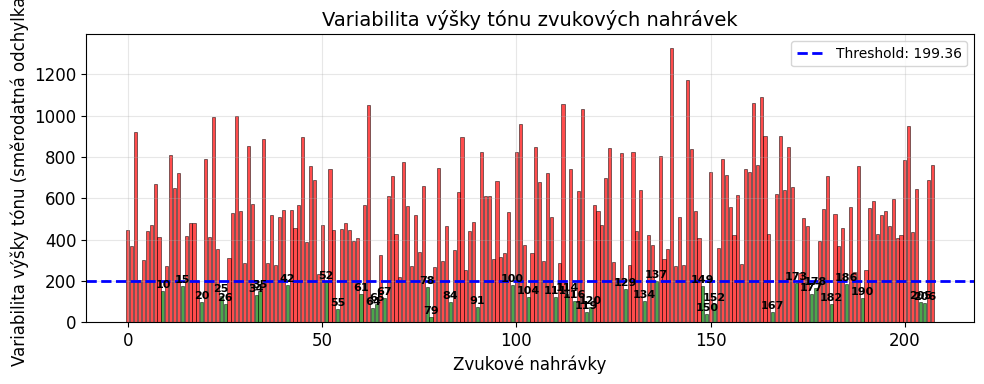

In [52]:
# 16 Generate Visualizations

print("\n4. Generating visualizations...")
plot_pitch_variability(results["pitch_plot_data"])


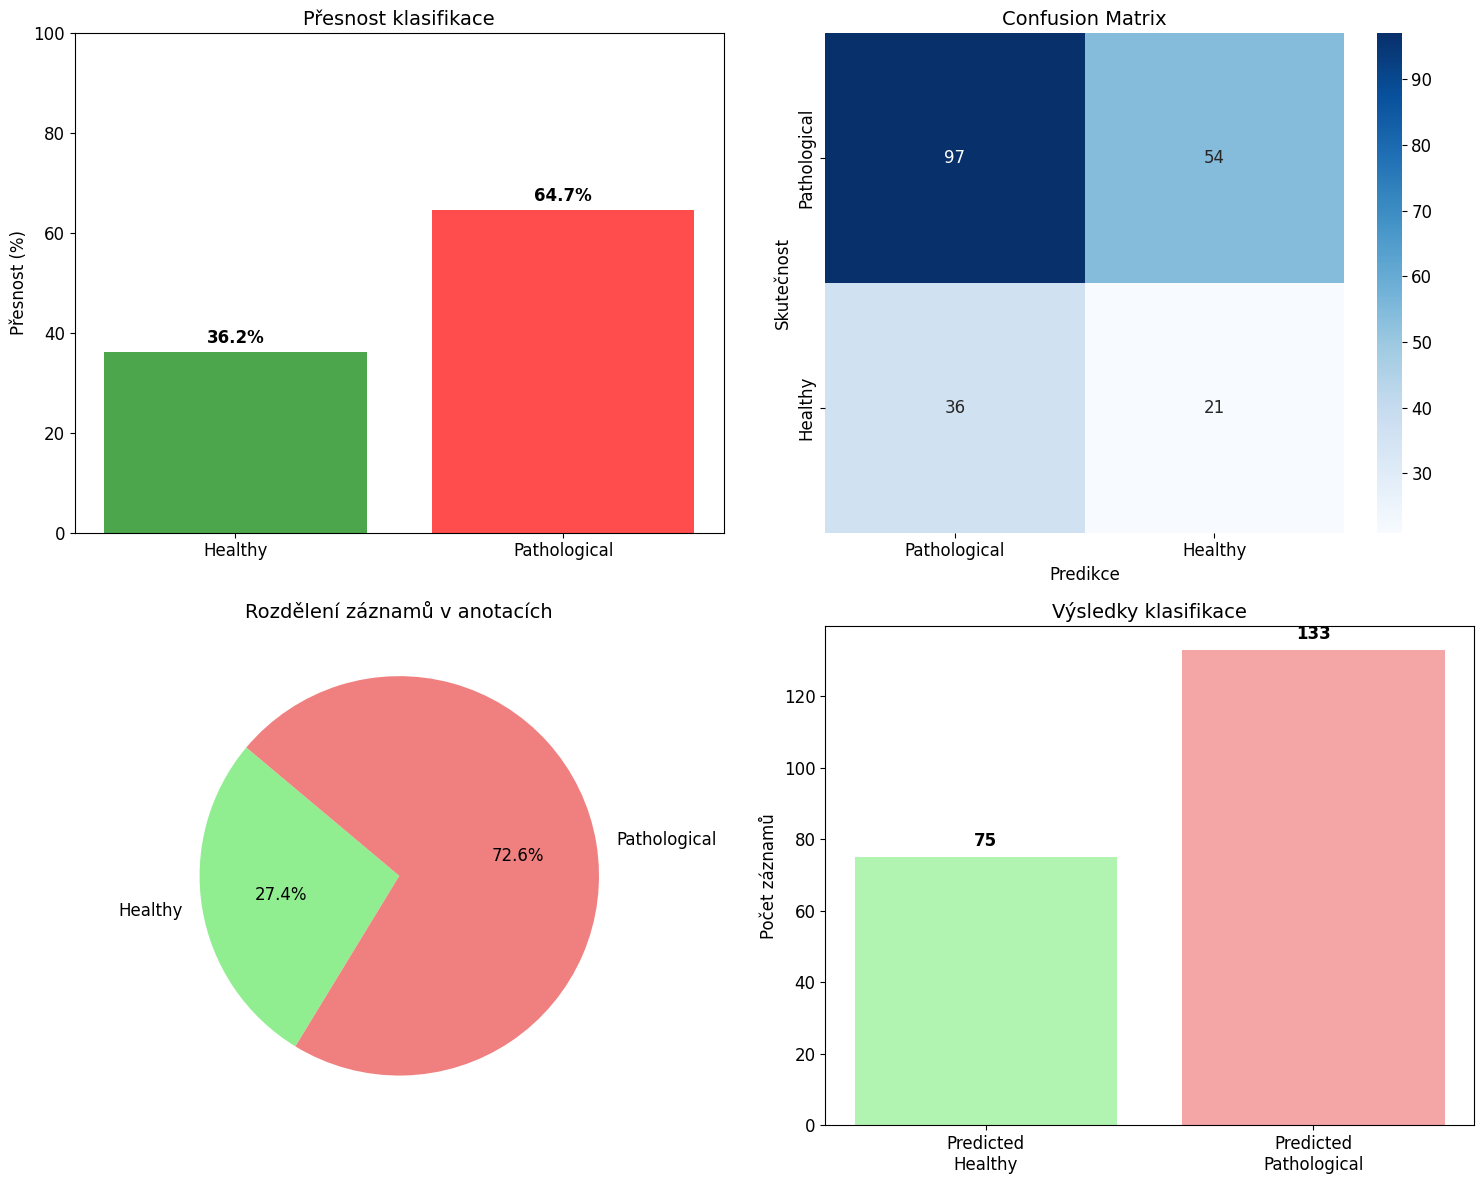

In [53]:
# 17 Comprehensive Results Visualization

plot_comprehensive_results(results["comprehensive_plot_data"])


In [54]:
# 18 Final Evaluation

print("\n5. Final evaluation...")
final_metrics = results["final_metrics"]
print("\n" + "=" * 50)
print("FINAL EVALUATION RESULTS")
print("=" * 50)
print(f"Total samples: {final_metrics.total_samples}")
print(f"Correctly classified: {final_metrics.correct_predictions}")
print(f"Overall accuracy: {final_metrics.overall_accuracy:.2f}%")
print(
    f"Healthy accuracy: {final_metrics.healthy_accuracy:.2f}% ({final_metrics.healthy_correct}/{final_metrics.healthy_total})"
)
print(
    f"Pathological accuracy: {final_metrics.pathological_accuracy:.2f}% ({final_metrics.pathological_correct}/{final_metrics.pathological_total})"
)
print("=" * 50)

print("\nAnalysis completed successfully!")
print(f"Final accuracy: {final_metrics.overall_accuracy:.2f}%")



5. Final evaluation...

FINAL EVALUATION RESULTS
Total samples: 208
Correctly classified: 118
Overall accuracy: 56.73%
Healthy accuracy: 36.84% (21/57)
Pathological accuracy: 64.24% (97/151)

Analysis completed successfully!
Final accuracy: 56.73%


### Finální vyhodnocení klasifikačního modelu kombinujícího více metod

Tento kód představuje závěrečnou fázi evaluace klasifikačního modelu, která sumarizuje výsledky analýzy na kompletním testovacím datasetu. Kód načítá finální metriky uložené v proměnné `results["final_metrics"]` a prezentuje je v přehledném formátu s jasně strukturovaným výstupem.

Struktura výstupu zahrnuje celkový počet analyzovaných vzorků (208 vzorků), počet správně klasifikovaných případů (118) a celkovou přesnost modelu (56,73 %). Tato celková přesnost se vypočítává jako poměr správně klasifikovaných vzorků k celkovému počtu testovaných vzorků.

Model vykazuje výraznou asymetrii ve výkonnosti mezi jednotlivými třídami. Přesnost pro zdravé vzorky dosahuje pouze 36,84 % (21 správně klasifikovaných ze 57 celkových zdravých vzorků), zatímco přesnost pro patologické vzorky je podstatně vyšší - 64,24 % (97 správně klasifikovaných ze 151 patologických vzorků).

Tato disproporce v klasifikační výkonnosti naznačuje, že model má tendenci klasifikovat vzorky jako patologické, což může být způsobeno nevyvážeností trénovacího datasetu nebo specifickými charakteristikami příznaků. Nízká senzitivita pro zdravé vzorky může být problematická v klinickém kontextu.

Celková přesnost 56,73 % je poměrně nízká a naznačuje, že model má omezenou praktickou použitelnost. V praxi by taková úroveň přesnosti mohla vést k vysokému počtu falešně pozitivních nebo falešně negativních diagnóz.

Vysoká specificita pro patologické případy (64,24 %) oproti nízké senzitivitě pro zdravé případy (36,84 %) může indikovat, že model je konzervativní a má tendenci identifikovat patologii i tam, kde se nevyskytuje. Toto chování může být výsledkem dominance patologických vzorků v trénovacím datasetu.

Pro zlepšení výkonnosti modelu by bylo vhodné provést vyvážení datasetu, optimalizaci hyperparametrů nebo použití pokročilejších technik strojového učení. Současný stav modelu vyžaduje další vývoj.

### Porovnání s výsledky klasifikace založené na variabilitě výšky tónu

Při srovnání finálních výsledků s předchozími výsledky klasifikace založené na variabilitě výšky tónu (Pitch Variability Classification) se objevují zajímavé rozdíly ve výkonnosti. Metoda založená na variabilitě výšky tónu dosahuje vyšší celkové přesnosti 67,8 % (141/208) ve srovnání s finální přesností 56,73 % (118/208).

Analýza výkonnosti podle tříd odhaluje podobné trendy v obou přístupech. Metoda založená na variabilitě výšky tónu vykazuje zdravý recall pouze 26,3 % (15/57), což je nižší než finální přesnost pro zdravé vzorky 36,84 % (21/57). Naopak patologický recall u metody variability výšky tónu dosahuje 83,4 % (126/151), což převyšuje finální patologickou přesnost 64,24 % (97/151).

Toto srovnání naznačuje, že metoda založená na variabilitě výšky tónu s prahem 199,360 poskytuje lepší celkovou diskriminační schopnost než finální kombinovaný přístup. Oba modely však vykazují stejnou problematickou charakteristiku - nízkou senzitivitu pro zdravé vzorky a vyšší specificitu pro patologické případy.

Rozdíl ve výkonnosti mezi jednotlivými přístupy může indikovat, že variabilita výšky tónu je silnějším diskriminačním rysem než kombinace více akustických parametrů použitá ve finálním modelu. Alternativně může jít o efekt přetrénování nebo nevhodné kombinace příznaků ve finálním modelu.

Nižší výkonnost finálního modelu ve srovnání s jednodušším přístupem založeným na jediném parametru naznačuje nutnost přehodnocení strategie výběru příznaků a jejich kombinace. Komplexnější model nemusí nutně znamenat lepší výkonnost, pokud není správně optimalizován.

Pro budoucí vývoj by bylo vhodné prozkoumat, zda kombinace variability výšky tónu s dalšími parametry může překonat výkonnost jednotlivých přístupů, případně aplikovat techniky redukce dimenzionality nebo výběru příznaků pro identifikaci nejinformativnějších charakteristik hlasu při diagnostice patologií.

In [34]:
# 19 Optional - Data Exploration

# Optional: Explore the extracted features
features = results["features"]
print(f"Number of samples: {features.n_samples}")
print(
    f"Pitch variability range: {min(features.pitch_variabilities):.2f} - {max(features.pitch_variabilities):.2f}"
)
print(f"HNR range: {min(features.hnr_scores):.2f} - {max(features.hnr_scores):.2f}")
print(f"ZCR range: {min(features.zcr_values):.4f} - {max(features.zcr_values):.4f}")
print(
    f"Spectral centroid range: {min(features.spectral_centroid_values):.2f} - {max(features.spectral_centroid_values):.2f}"
)


Number of samples: 208
Pitch variability range: 25.95 - 1326.57
HNR range: 0.19 - 577.79
ZCR range: 0.0649 - 0.3227
Spectral centroid range: 884.45 - 1747.13


In [ ]:
# 20 Optional - Individual Feature Analysis

import pandas as pd

feature_df = pd.DataFrame(
    {
        "pitch_variability": features.pitch_variabilities,
        "hnr": features.hnr_scores,
        "zcr": features.zcr_values,
        "spectral_centroid": features.spectral_centroid_values,
        "classification": results["combined_result"].classifications,
        "annotation": load_result.annotations,
    }
)

print("Feature statistics by classification:")
print(feature_df.groupby("classification").describe())


Feature statistics by classification:
               pitch_variability                                     \
                           count        mean         std        min   
classification                                                        
Healthy                     75.0  422.210431  245.163577  25.954614   
Pathological               133.0  508.671691  279.346026  40.668579   

                                                                   hnr  \
                       25%         50%         75%          max  count   
classification                                                           
Healthy         224.663656  417.850109  562.125046  1087.938567   75.0   
Pathological    292.327762  479.695642  719.766973  1326.566201  133.0   

                            ...       zcr           spectral_centroid  \
                      mean  ...       75%       max             count   
classification              ...                                         
Healthy         

### Doplňující analýza extrahovaných akustických příznaků

Výše uvedený kód provádí detailní exploraci extrahovaných akustických příznaků z hlasových vzorků s cílem lépe porozumět charakteristikám datové sady a distribucím jednotlivých parametrů. První část kódu zobrazuje základní statistiky celé datové sady, zatímco druhá část analyzuje rozdíly mezi zdravými a patologickými vzorky pomocí deskriptivní statistiky.

Základní charakteristiky datové sady odhalují široké rozmezí hodnot jednotlivých příznaků. Variabilita výšky tónu (pitch variability) se pohybuje v rozsahu 25,95 až 1326,57, což naznačuje značnou heterogenitu hlasových projevů v analyzovaném souboru. Harmonicko-šumový poměr (HNR) vykazuje extrémně široký rozsah od 0,19 do 577,79, což může indikovat přítomnost vzorků s velmi různou kvalitou hlasu.

Poměr průchodů nulou (ZCR) se pohybuje v relativně úzkém rozsahu 0,0649 až 0,3227, což odpovídá typickým hodnotám pro hlasové signály. Spektrální centroid dosahuje hodnot mezi 884,45 a 1747,13 Hz, což odráží různorodost spektrálních charakteristik analyzovaných hlasů v datové sadě.

Srovnání středních hodnot mezi zdravými a patologickými vzorky odhaluje významné rozdíly v jednotlivých příznacích. Patologické vzorky vykazují vyšší průměrnou variabilitu výšky tónu (508,67) ve srovnání se zdravými vzorky (422,21), což podporuje hypotézu o snížené hlasové stabilitě u pacientů s patologiemi.

Nejmarkantnější rozdíl se objevuje v hodnotách HNR, kde zdravé vzorky dosahují průměrné hodnoty 102,46, zatímco patologické vzorky pouze 7,46. Tento výrazný rozdíl naznačuje, že harmonicko-šumový poměr je silným diskriminačním rysem pro identifikaci hlasových patologií, protože zdravé hlasy mají typicky vyšší harmonický obsah a nižší úroveň šumu.

Spektrální centroid také vykazuje rozdíly mezi skupinami, přičemž patologické vzorky mají vyšší průměrnou hodnotu (1316,06 Hz) oproti zdravým vzorkům (1158,25 Hz). Tato tendence může odrážet změny v hlasové kvalitě a spektrálním rozložení energie u osob s hlasovými poruchami.

Vysoké hodnoty směrodatných odchylek u všech příznaků, zejména u variability výšky tónu a HNR, indikují značnou variabilitu uvnitř jednotlivých skupin. Tato heterogenita tak komplikuje klasifikační úkol a vyžaduje robustní přístupy, které dokážou zachytit široké spektrum hlasových projevů.

## Závěr

Dosažené výsledky naznačují, že jednodušší přístup založený na jediném akustickém příznaku může překonávat komplexnější modely kombinující více parametrů. Toto pozorování poukazuje na možné problémy s optimalizací složitějších modelů nebo na nevhodnou kombinaci příznaků ve finálním přístupu.

Výrazná asymetrie ve výkonnosti mezi třídami indikuje zkreslení modelu směrem k identifikaci patologických případů. Tato tendence může být způsobena nevyvážeností datové sady, kde patologické vzorky tvoří většinu, nebo specifickými charakteristikami vybraných příznaků, které lépe rozlišují patologické projevy.

Nízká celková přesnost obou modelů (56,73 % a 67,8 %) naznačuje omezení současného přístupu pro praktické klinické nasazení. V medicínském kontextu by taková úroveň přesnosti mohla vést k vysokému počtu chybných diagnóz, což limituje klinickou použitelnost navržených metod.

Budoucí vývoj by se měl zaměřit na řešení identifikovaných limitací. Priority zahrnují vyvážení datové sady pro eliminaci zkreslení, optimalizaci hyperparametrů a výběr nejinformativnějších příznaků pomocí pokročilých technik strojového učení.

Implementace pokročilejších klasifikačních algoritmů, jako jsou support vector machines, random forests nebo neuronové sítě, by mohla zlepšit diskriminační schopnost modelu. Současně by bylo vhodné prozkoumat dodatečné akustické příznaky.

Rozšíření datové sady o větší počet vyváženě reprezentovaných zdravých a patologických vzorků by mohlo významně zlepšit robustnost a generalizační schopnost modelů. Validace na nezávislých datových sadách by poskytla objektivnější odhad výkonnosti.